In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim

from utils import load_rnacompete_data
import utils
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Set seed for reproducibility
utils.configure_seed(42)

# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

### LSTM (Long Short-Term Memory) model - Bidiretional

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.layer_dim = n_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        
        # input_dim deve ser 4 (A,C,G,U) pois os dados são One-Hot
        self.lstm = nn.LSTM(input_dim,
                            hidden_dim//2 if bidirectional else hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True) # If set to True, input/output tensors are provided as (batch, seq_len, features) instead of (seq_len, batch, features)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # output = [batch size, sent len, hid dim * num directions]
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        output, (hidden, cell) = self.lstm(x)

        #hidden = [batch size, hid dim * num directions]
        if self.bidirectional:
            # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        else:
            hidden = hidden[-1,:,:]
        
        hidden = self.dropout(hidden) # aplica dropout
                
        return self.fc(hidden)

### CNN 1D model - o filtro move-se numa única direção (sequência)

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(CNN, self).__init__()
        self.num_layers = num_layers
        
        # define convolution and linear layers
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=10, padding='same') # sequência de input é (Batch, 4, 41) após permute

        if num_layers > 1:
            self.conv2 = nn.Conv1d(hidden_dim, 2 * hidden_dim, kernel_size=5, padding='same')
            conv_out_dim = hidden_dim * 2
        else:
            conv_out_dim = hidden_dim
       
        # Global Max Pooling (reduz a sequência inteira a um vetor de características)
        self.global_pool = nn.AdaptiveMaxPool1d(output_size=1)
        
        self.activation = nn.ReLU()
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear(conv_out_dim, output_dim)

    def forward(self, x):
        # Input: [Batch, Length, Channels] -> Permute para [Batch, Channels, Length]
        x = x.permute(0, 2, 1)

        x = self.activation(self.conv1(x))
        x = self.dropout(x)
        
        if self.num_layers > 1:
            x = self.activation(self.conv2(x))
            x = self.dropout(x)
        
        # Output: [Batch, Channels, Length] -> Global Pool -> [Batch, Channels, 1]
        x = self.global_pool(x).squeeze(-1)  # obter o output por sequência, não por nucleótido
        x = self.dropout(x)
        
        x = self.fc1(x)
        
        return x

#### Train and Evaluate the models

In [ ]:
def train(model, train_dataloader, optimizer, criterion):

    epoch_loss = 0

    model.train()

    for batch in tqdm(train_dataloader):
        # Unpack the batch: (Sequences, Intensities, ValidityMasks)
        x, y, mask = batch

        # x shape:    (Batch, 41, 4)  <- One-Hot Encoded Sequence
        # y shape:    (Batch, 1)      <- Normalized Binding Intensity
        # mask shape: (Batch, 1)      <- 1.0 if valid, 0.0 if NaN

        optimizer.zero_grad()
        
        # forward pass
        predictions = model(x)

        # Calculate Loss - use the mask to zero out invalid data points
        loss = criterion(predictions, y, mask)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(train_dataloader)

In [ ]:
def evaluate(model, eval_dataloader, criterion):

    epoch_loss = 0
    all_preds = []
    all_targets = []
    all_masks = []

    model.eval()

    with torch.no_grad():

        for batch in tqdm(eval_dataloader):
            # Unpack the batch: (Sequences, Intensities, ValidityMasks)
            x, y, mask = batch

            # x shape:    (Batch, 41, 4)  <- One-Hot Encoded Sequence
            # y shape:    (Batch, 1)      <- Normalized Binding Intensity
            # mask shape: (Batch, 1)      <- 1.0 if valid, 0.0 if NaN

            # forward pass
            predictions = model(x)

            # Calculate Loss - use the mask to zero out invalid data points
            loss = criterion(predictions, y, mask)
            epoch_loss += loss.item()

            # Guardar tensores
            all_preds.append(predictions.cpu())
            all_targets.append(y.cpu())
            all_masks.append(mask.cpu())
    
    # Concatenar tudo num único tensor grande
    full_preds = torch.cat(all_preds)
    full_targets = torch.cat(all_targets)
    full_masks = torch.cat(all_masks)

    # Calcular Spearman Correlation 
    spearman_corr = utils.masked_spearman_correlation(full_preds, full_targets, full_masks)

    return epoch_loss / len(eval_dataloader), spearman_corr

#### Load the data

In [ ]:
# Load Data for a specific protein (e.g., 'RBFOX1', 'PTB', 'A1CF') -> Neste projeto usamos RBFOX1
# This returns a PyTorch TensorDataset ready for training
train_dataset = load_rnacompete_data(protein_name='RBFOX1', split='train')
val_dataset   = load_rnacompete_data(protein_name='RBFOX1', split='val')
test_dataset  = load_rnacompete_data(protein_name='RBFOX1', split='test')

# Wrap in a standard PyTorch DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_epochs = 30

In [ ]:
import itertools

hyper_params_LSTM = {
    'num_layers': [1, 2],
    'width': [64, 128],
    'dropout': [0, 0.25],
    'lr_rate': [0.001, 0.0001],
}

# Criar todas as combinações
keys, values = zip(*hyper_params_LSTM.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_val_corr_LSTM = -1
best_config_LSTM = None
best_train_losses_LSTM = []
best_valid_losses_LSTM = []

for config in combinations:
    print(f"\n Testing config: {config}")
    
    model_LSTM = LSTM(input_dim=4,
                    hidden_dim=config['width'], 
                    output_dim=1, 
                    n_layers=config['num_layers'],
                    bidirectional=True, 
                    dropout=config['dropout'], 
                    )
    
    optimizer = optim.Adam(model_LSTM.parameters(), lr=config['lr_rate'], weight_decay=1e-4)
    
    criterion = utils.masked_mse_loss

    # listas para guardar os resultados para os plots
    train_loss_LSTM = []
    valid_loss_LSTM = []
    valid_corrs_LSTM = []

    # LSTM training loop
    for epoch in range(num_epochs):
        train_loss = train(model_LSTM, train_loader, optimizer, criterion)
        valid_loss, valid_corr = evaluate(model_LSTM, valid_loader, criterion)

        # para os plots
        train_loss_LSTM.append(train_loss)
        valid_loss_LSTM.append(valid_loss)
        valid_corrs_LSTM.append(valid_corr)

        print(f'Epoch: {epoch+1:02}')
        print(f'\t Train Loss: {train_loss:.4f}')
        print(f'\t Val. Loss: {valid_loss:.4f} | Val. Corr: {valid_corr:.4f}')

    # Guardar melhor modelo baseado no Spearman (Validação) 
    if valid_corr > best_val_corr_LSTM:
        best_val_corr_LSTM = valid_corr
        best_config_LSTM = config
        best_train_losses_LSTM = train_loss_LSTM[:] # cópia da lista
        best_valid_losses_LSTM = valid_loss_LSTM[:] 
        # torch.save(model.state_dict(), 'best_lstm.pth')

print(f"Melhor Configuração: {best_config_LSTM} com Spearman: {best_val_corr_LSTM}")

In [ ]:
hyper_params_CNN = {
    'num_layers': [1, 2],
    'width': [64, 128],
    'dropout': [0, 0.25],
    'lr_rate': [0.001, 0.0001],
}

# Criar todas as combinações
keys, values = zip(*hyper_params_CNN.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_val_corr_CNN = -1
best_config_CNN = None
best_train_losses_CNN = []
best_valid_losses_CNN = []

criterion = utils.masked_mse_loss

for config in combinations:
    print(f"\n Testing config: {config}")

    model_CNN = CNN(input_dim=4, hidden_dim=config['width'], output_dim=1, num_layers=config['num_layers'], dropout=config['dropout'])

    optimizer = optim.Adam(model_CNN.parameters(), lr=config['lr_rate'], weight_decay=1e-4)
    
    # listas para guardar os resultados para os plots
    train_loss_CNN = []
    valid_loss_CNN = []
    valid_corrs_CNN = []

    # CNN training loop
    for epoch in range(num_epochs):
        train_loss = train(model_CNN, train_loader, optimizer, criterion)
        valid_loss, valid_corr = evaluate(model_CNN, valid_loader, criterion)

        # para os plots
        train_loss_CNN.append(train_loss)
        valid_loss_CNN.append(valid_loss)
        valid_corrs_CNN.append(valid_corr)

        print(f'Epoch: {epoch+1:02}')
        print(f'\t Train Loss: {train_loss:.4f}')
        print(f'\t Val. Loss: {valid_loss:.4f} | Val. Corr: {valid_corr:.4f}')

    # Guardar melhor modelo baseado no Spearman (Validação) 
    if valid_corr > best_val_corr_CNN:
        best_val_corr_CNN = valid_corr
        best_config_CNN = config
        best_train_losses_CNN = train_loss_CNN[:] # cópia da lista
        best_valid_losses_CNN = valid_loss_CNN[:]   
        # torch.save(model.state_dict(), 'best_CNN.pth')

print(f"Melhor Configuração: {best_config_CNN} com Spearman: {best_val_corr_CNN}")

#### Plots for loss on train and validation sets

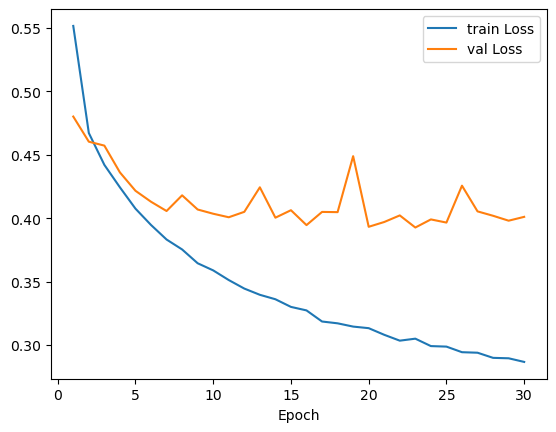

In [ ]:
plot_losses_LSTM = {
    'train Loss': best_train_losses_LSTM,
    'val Loss': best_valid_losses_LSTM
}

plot_losses_CNN = {
    'train Loss': best_train_losses_CNN,
    'val Loss': best_valid_losses_CNN
}

epochs_range = range(1, num_epochs + 1)

utils.plot(epochs_range, plot_losses_LSTM, filename='loss_LSTm.pdf', ylim=None)
utils.plot(epochs_range, plot_losses_CNN, filename='loss_CNN.pdf', ylim=None)